# vitalAperiodic

The vitalAperiodic table provides invasive vital sign data which is interfaced into eCareManager at irregular intervals. Unlike most tables in eICU-CRD, vitalAperiodic does not use an entity-attribute-value model, but rather has an individual column to capture each data element. Columns available include:

* Blood pressures: nonInvasiveSystolic, nonInvasiveDiastolic, nonInvasiveMean
* Cardiac output measures: cardiacOutput, cardiacInput
* Systemic circulation measures: svr, svri, pvr, pvri
* Pulmonary pressures: pulmonary artery occlusion pressure (paop)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [3]:
from sqlalchemy import create_engine
con= create_engine('postgresql://eicu@localhost:5432/eicu')

## Examine a single patient

In [4]:
patientunitstayid = 145467

In [5]:
query = query_schema + """
select *
from vitalaperiodic
where patientunitstayid = {}
order by observationoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.set_index('observationoffset', inplace=True)
df.sort_index(inplace=True)
df.head()

,vitalaperiodicid,patientunitstayid,noninvasivesystolic,noninvasivediastolic,noninvasivemean,paop,cardiacoutput,cardiacinput,svr,svri,pvr,pvri
observationoffset,,,,,,,,,,,,
4,4223721,145467,113.0,62.0,81.0,None,NaN,NaN,NaN,NaN,NaN,NaN
44,4223722,145467,NaN,NaN,NaN,None,3.9,1.9,1496.0,3099.0,123.0,255.0
90,4223723,145467,NaN,NaN,NaN,None,4.3,2.1,1357.0,2810.0,112.0,231.0
275,4223724,145467,NaN,NaN,NaN,None,4.5,2.2,1012.0,2097.0,107.0,221.0
671,4223725,145467,NaN,NaN,NaN,None,7.8,3.8,NaN,NaN,72.0,149.0


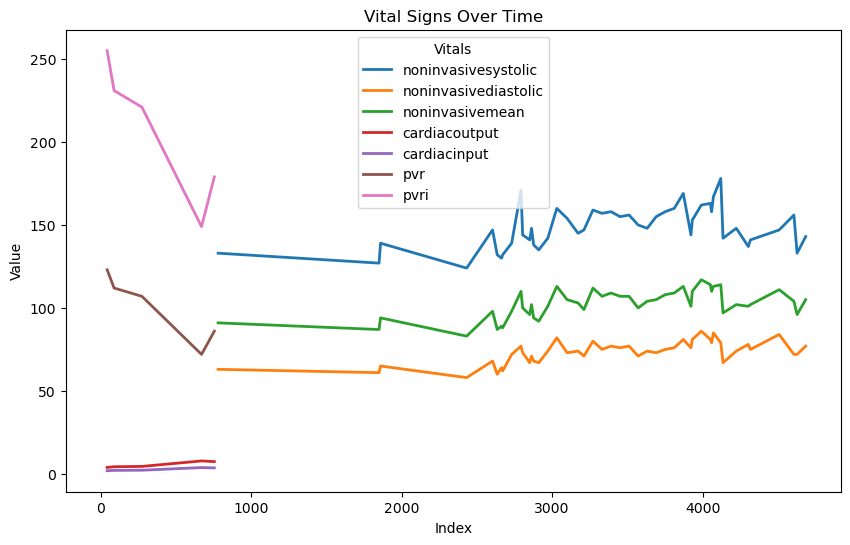

In [7]:
vitals = ['noninvasivesystolic', 'noninvasivediastolic', 'noninvasivemean',
          'cardiacoutput', 'cardiacinput',
          'pvr', 'pvri']

df[vitals].plot(figsize=(10, 6), linewidth=2)

plt.xlabel('Index')  
plt.ylabel('Value')
plt.title('Vital Signs Over Time')

plt.legend(title='Vitals')

plt.show()


In [ ]:
# list of columns to plot
vitals = ['noninvasivesystolic', 'noninvasivediastolic', 'noninvasivemean',
          #'paop',
          'cardiacoutput', 'cardiacinput',
          'pvr', 'pvri']
# we exclude  'svr', 'svri' from the plot as their scale is too high
# we exclude 'paop' as it's all none
df[vitals].vgplot.line()

## Hospitals with data available

In [8]:
query = query_schema + """
with t as
(
select distinct patientunitstayid
from vitalaperiodic
)
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct t.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join t
  on pt.patientunitstayid = t.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
11,73,7059,6635,93.993483
54,167,6092,5585,91.677610
106,264,5237,5018,95.818217
184,420,4679,4432,94.721094
134,338,4277,4181,97.755436
90,243,4243,4105,96.747584
58,176,4328,3931,90.827172
71,199,4240,3890,91.745283
206,458,3701,3642,98.405836
80,208,3650,3581,98.109589


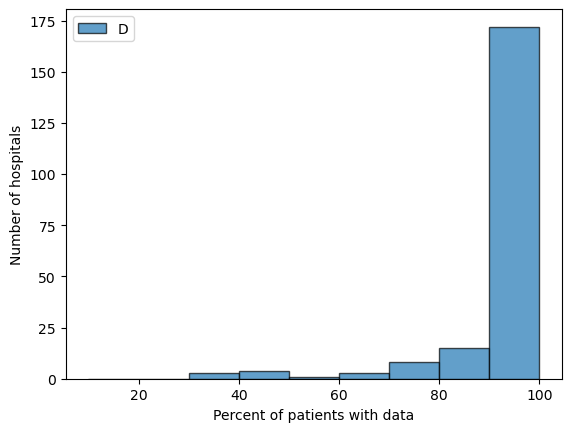

In [10]:
bins=[10,20,30,40,50,60,70,80,90,100]
plt.hist(df['data completion'], bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Percent of patients with data')
plt.ylabel('Number of hospitals')
plt.legend('Data completion')
plt.show()

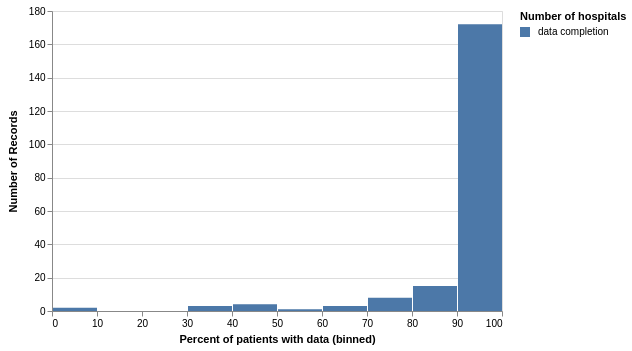

In [7]:
df[['data completion']].vgplot.hist(bins=10,
                                    var_name='Number of hospitals',
                                    value_name='Percent of patients with data')

Most hospitals in eICU have good data coverage for the vitalaperiodic table.